
# HS300 — XGBoost Stock Selection × RSRS & T‑Sharpe Timing (Clean & Explained)

This notebook is a **clean, robust, and fully explained** version that builds a combined equity strategy for HS300 constituents:

**What you'll get**
- Load factor and price data with robust fallbacks.
- Train **XGBoost** to rank stocks from `factor_*` features.
- Construct a **market‑neutral selection** (long top p%, short bottom p%) with **turnover‑based fees applied only on rebalance days**.
- Compute timing overlays:
  - **RSRS (Rolling Regression Slope z-score)** with **quantile thresholds** (enter on 70%, exit on 30% by default).
  - **T‑Sharpe** (rolling Sharpe of benchmark).
- Build and compare strategies:
  - **Selection‑only** (Gross & Net)
  - **RSRS timing** (Gross & Net; timing-only fees on flips)
  - **T‑Sharpe timing** (Gross & Net; timing-only fees on flips)
  - **OR timing** (RSRS OR T‑Sharpe) (Gross & Net; timing-only fees on flips)
  - **Partial Timing**: first enter 100%, exit halves exposure, re‑enter restores to 100% (Gross & Net; timing-only fees proportional to exposure change)
- Plot **equity curves** and show a consolidated **performance table**.

> ⚙️ Change `REBALANCE_DAYS` to 5 / 10 / 20 etc. to rebalance less often — selection fees will automatically follow that cadence.


## 1) Configuration

In [80]:

# Paths: try Windows drive first, then local /mnt/data copies as fallback.
WINDOWS_BASE = "F:/Code_Crunch/test"
LINUX_BASE   = "/mnt/data"

FACTOR_CANDIDATES = [
    f"{WINDOWS_BASE}/merged_factor.csv",
    f"{LINUX_BASE}/merged_factor.csv",
    f"{WINDOWS_BASE}/factors_daily_tech25.csv",
    f"{LINUX_BASE}/factors_daily_tech25.csv",
]
PRICE_CANDIDATES = [
    f"{WINDOWS_BASE}/hs300_2020_2025_dynamic.csv",
    f"{LINUX_BASE}/hs300_2020_2025_dynamic.csv",
]
BENCH_CANDIDATES = [
    f"{WINDOWS_BASE}/HS300_daily_2014_2024.csv",
    f"{LINUX_BASE}/HS300_daily_2014_2024.csv",
]

# Columns in your files
DATE_COL = "trade_date"
TICKER_COL = "ts_code"

# Modeling / Portfolio
TRAIN_TEST_SPLIT_RATIO = 0.7
PORTFOLIO_PERCENTILE = 10   # long top p%, short bottom p%
REBALANCE_DAYS = 1          # ⬅ change to 5/10/20, etc.
STARTING_CAPITAL = 100_000

# RSRS (quantile thresholds)
RSRS_WINDOW = 18
RSRS_ZSCORE_WINDOW = 600
RSRS_ENTER_Q = 0.70     # enter if RSRS z > 70th percentile
RSRS_EXIT_Q  = 0.30     # exit  if RSRS z < 30th percentile

# T‑Sharpe (timing on benchmark quality)
TSHARPE_LOOKBACK = 60
TSHARPE_ENTER = 0
TSHARPE_EXIT  = -0.1

# Trading costs
FEE_PER_SIDE = 0.0005        # 5 bps commission/impact per side
SLIPPAGE_PER_SIDE = 0.0002   # 2 bps slippage per side
FEE_PER_SIDE_TOTAL = FEE_PER_SIDE + SLIPPAGE_PER_SIDE


## 2) Imports & Helper Functions

In [81]:

import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
warnings.filterwarnings("ignore")

# ML
try:
    import xgboost as xgb
except Exception as e:
    raise RuntimeError("xgboost is required for this notebook.") from e

# RSRS requires OLS
import statsmodels.api as sm

# Optional performance helper (if provided)
sys.path.append("/mnt/data")
try:
    from performance import Strategy_performance
except Exception as _e:
    Strategy_performance = None
    print("Note: performance.py not found. Performance table may be skipped.", _e)

def choose_existing(candidates):
    """Pick the first existing path from a candidate list."""
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"No existing file found among: {candidates}")

def normalize_keys(df: pd.DataFrame, date_col: str, ticker_col: str) -> pd.DataFrame:
    """Standardize date & ticker columns for safe merging."""
    df = df.copy()
    df[date_col] = (
        df[date_col].astype(str).str.replace(r"[^0-9]", "", regex=True).str.slice(0,8).str.zfill(8)
    )
    df[ticker_col] = df[ticker_col].astype(str).str.strip()
    return df

def parse_date(series: pd.Series) -> pd.Series:
    """Parse date from YYYYMMDD (or fallback to best-effort)."""
    try:
        return pd.to_datetime(series, format="%Y%m%d", errors="raise")
    except Exception:
        return pd.to_datetime(series, errors="coerce")


## 3) Load & Prepare Data

In [82]:

# Pick files
factor_path = choose_existing(FACTOR_CANDIDATES)
price_path  = choose_existing(PRICE_CANDIDATES)
bench_path  = choose_existing(BENCH_CANDIDATES)
print("Using factor:", factor_path)
print("Using prices:", price_path)
print("Using benchmark:", bench_path)

# Load raw
df_f = pd.read_csv(factor_path)
df_p = pd.read_csv(price_path)
df_b = pd.read_csv(bench_path)

# Normalize keys
df_f = normalize_keys(df_f, DATE_COL, TICKER_COL)
df_p = normalize_keys(df_p, DATE_COL, TICKER_COL)

# Merge to a panel (Date, Ticker) index
df_m = pd.merge(df_f, df_p, on=[TICKER_COL, DATE_COL], how="inner", suffixes=("", "_p")).drop_duplicates([TICKER_COL, DATE_COL])
df_m[DATE_COL] = parse_date(df_m[DATE_COL])

# Choose "Close": prefer explicit close; else next-day pre_close; else fallback
close = None
for c in ["close", "Close"]:
    if c in df_m.columns:
        close = pd.to_numeric(df_m[c], errors="coerce")
        break
if close is None and "pre_close" in df_m.columns:
    # next day's pre_close as effective "close" for today's return calc
    close = df_m.groupby(TICKER_COL)["pre_close"].shift(-1)
if close is None:
    for c in ["price", "last", "open"]:
        if c in df_m.columns:
            close = pd.to_numeric(df_m[c], errors="coerce")
            break
if close is None:
    raise ValueError("Could not determine a Close series from merged data.")
df_m["Close"] = close

panel = df_m.rename(columns={DATE_COL:"Date", TICKER_COL:"Ticker"}).set_index(["Date","Ticker"]).sort_index()

# Factor columns
factor_cols = [c for c in panel.columns if str(c).startswith("factor_")]
if not factor_cols:
    raise ValueError("No 'factor_*' columns found.")

# Benchmark (use provided close)
df_b = df_b.copy()
df_b[DATE_COL] = parse_date(df_b[DATE_COL].astype(str).str.replace(r"[^0-9]","", regex=True).str.slice(0,8))
b_close = None
for c in ["close","Close"]:
    if c in df_b.columns:
        b_close = pd.to_numeric(df_b[c], errors="coerce")
        break
if b_close is None:
    raise ValueError("Benchmark file must include a 'close' column.")
df_b = df_b.assign(Close=b_close).rename(columns={DATE_COL:"Date"}).set_index("Date").sort_index()
bm_daily_ret = df_b["Close"].pct_change().fillna(0.0)

print("Panel shape:", panel.shape)
print("Benchmark span:", bm_daily_ret.index.min().date(), "→", bm_daily_ret.index.max().date())


Using factor: F:/Code_Crunch/test/factors_daily_tech25.csv
Using prices: F:/Code_Crunch/test/hs300_2020_2025_dynamic.csv
Using benchmark: F:/Code_Crunch/test/HS300_daily_2014_2024.csv
Panel shape: (359826, 47)
Benchmark span: 2014-01-02 → 2024-12-31


## 4) Define Supervised Target & Train/Test Split

In [83]:

# Target: will stock outperform cross-sectional median return over next REBALANCE_DAYS?
REBAL = max(1, int(REBALANCE_DAYS))

df2 = panel.copy()
df2["Future_Return"] = df2.groupby(level="Ticker")["Close"].shift(-REBAL) / df2["Close"] - 1
median_cs = df2.groupby(level="Date")["Future_Return"].transform("median")
df2["Target"] = (df2["Future_Return"] > median_cs).astype(int)

# Keep rows where features + target + price are present
required = factor_cols + ["Target","Close"]
clean = df2.dropna(subset=required)

# Split by date (avoid leakage)
unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
split_idx = max(1, min(int(len(unique_dates)*TRAIN_TEST_SPLIT_RATIO), len(unique_dates)-1))
split_date = unique_dates[split_idx]

train = clean[clean.index.get_level_values("Date") < split_date]
test  = clean[clean.index.get_level_values("Date") >= split_date]

print("Train period:", train.index.get_level_values("Date").min().date(), "→", train.index.get_level_values("Date").max().date())
print("Test  period:",  test.index.get_level_values("Date").min().date(),  "→", test.index.get_level_values("Date").max().date())

X_train, y_train = train[factor_cols], train["Target"]
X_test  = test[factor_cols]


Train period: 2020-02-07 → 2023-07-11
Test  period: 2023-07-12 → 2024-12-30


## 5) Train XGBoost & Inspect Feature Importances

,Feature,Importance
0,factor_intraday_return,6.19%
1,factor_lower_shadow,6.01%
2,factor_atr_norm,5.49%
3,factor_overnight_return,5.01%
4,factor_turnover_cv,4.83%
5,factor_upper_shadow,4.61%
6,factor_bias_12,4.60%
7,factor_vol_spike,4.55%
8,factor_ma_align,4.47%
9,factor_macd_dea,4.47%


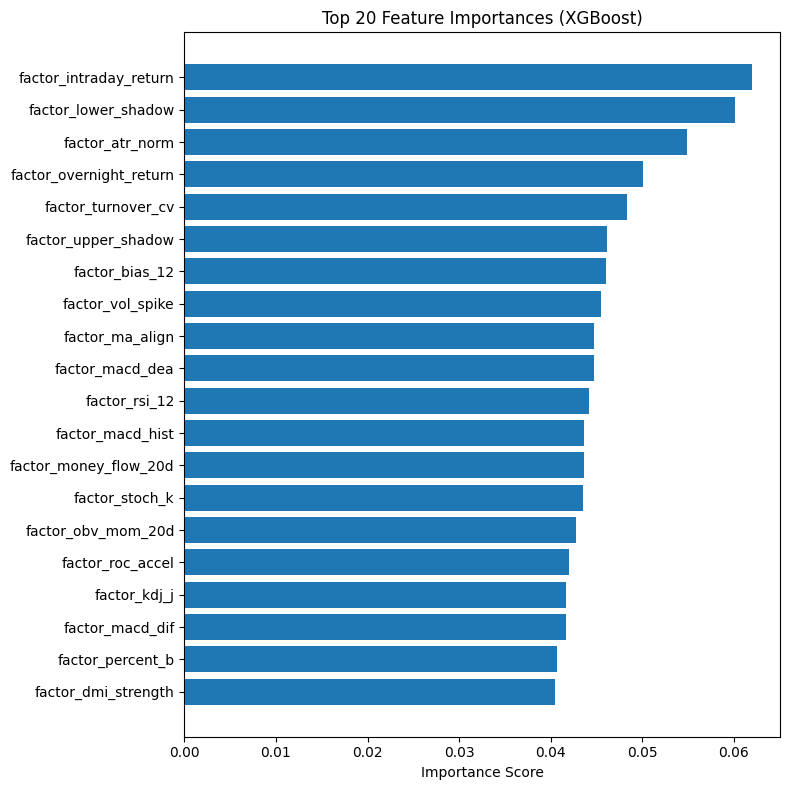

In [84]:

# Simple validation split from training period
vi = int(len(X_train)*0.85)
X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

# Fit with early stopping when available (keeps code version-portable)
fitted = False
try:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); fitted=True
except TypeError:
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[es], verbose=False); fitted=True
    except TypeError:
        pass
if not fitted:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# Show & plot importances
fi = pd.DataFrame({"Feature": factor_cols, "Importance": model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
display(fi.head(30))

def plot_feature_importance(fi, top_n=20):
    top = fi.head(top_n)
    plt.figure(figsize=(8, max(4, top_n*0.4)))
    plt.barh(list(reversed(top["Feature"].tolist())), list(reversed(top["Importance"].tolist())))
    plt.xlabel("Importance Score"); plt.title(f"Top {top_n} Feature Importances (XGBoost)")
    plt.tight_layout(); plt.show()

plot_feature_importance(fi, top_n=20)


## 6) Build Selection‑Only Long/Short (Gross)

In [85]:

# Rank by predicted probability on test dates; long top p%, short bottom p%.
proba = model.predict_proba(X_test)[:,1]
pred = X_test.copy(); pred["prob"] = proba

close_panel = panel["Close"].unstack(level="Ticker")
test_dates = sorted(pred.index.get_level_values("Date").unique())

all_rets = []                 # daily L/S returns
baskets_by_date = {}          # store long/short baskets to compute turnover-based fees later

for i in range(0, max(0, len(test_dates)-1), REBAL):
    d0 = test_dates[i]
    d1 = test_dates[min(i+REBAL, len(test_dates)-1)]
    row = pred.loc[d0]
    if isinstance(row, pd.Series): row = row.to_frame().T
    if row.shape[0] < 2: continue

    sorted_row = row.sort_values("prob", ascending=False)
    n = len(sorted_row)
    k = max(1, int(n * PORTFOLIO_PERCENTILE/100.0))
    long_tks  = sorted_row.head(k).index.tolist()
    short_tks = sorted_row.tail(k).index.tolist()
    baskets_by_date[d0] = {"long": set(long_tks), "short": set(short_tks)}

    cols = list(set(long_tks).union(set(short_tks)))
    try:
        price_slice = close_panel.loc[d0:d1, cols]
        stock_rets = price_slice.pct_change().iloc[1:]
        if stock_rets.empty: continue
        long_ret  = stock_rets[long_tks].mean(axis=1)
        short_ret = stock_rets[short_tks].mean(axis=1)
        ls = (long_ret - short_ret) / 2.0   # market‑neutral, equal gross each side
        ls.name = "LS"
        all_rets.append(ls)
    except Exception:
        continue

sel_rets = (pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float))
print("Selection-only observations:", len(sel_rets))


Selection-only observations: 357


## 7) Apply Turnover‑based Fees on Rebalance Days (Selection‑Only Net)

In [86]:
def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
    """
    Robust turnover and fee estimation for equal-weight L/S portfolios.
    Handles missing dates gracefully.
    """
    fee = pd.Series(0.0, index=sel_rets_index)
    prev_long, prev_short = set(), set()

    for d0 in sorted(baskets_by_date.keys()):
        current = baskets_by_date[d0]
        long_tks, short_tks = current["long"], current["short"]
        k = max(1, k_per_side)

        entries_long = len(long_tks - prev_long); exits_long = len(prev_long - long_tks)
        entries_short = len(short_tks - prev_short); exits_short = len(prev_short - short_tks)
        gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k

        fee_decimal = gross_turnover * fee_per_side_total

        # find first valid trading day >= d0
        later_dates = sel_rets_index[sel_rets_index >= d0]
        if len(later_dates) > 0:
            fee.loc[later_dates[0]] += fee_decimal

        prev_long, prev_short = long_tks, short_tks

    return fee

# --- Safety checks ---
if baskets_by_date:
    first_date = sorted(baskets_by_date.keys())[0]
    k_per_side = len(baskets_by_date[first_date]["long"])
else:
    k_per_side = 1

# --- Compute fees safely ---
sel_fee_series = compute_selection_fees_turnover(
    baskets_by_date=baskets_by_date,
    sel_rets_index=sel_rets.index,
    k_per_side=k_per_side,
    fee_per_side_total=FEE_PER_SIDE_TOTAL
)

selection_only_gross = sel_rets.copy()
selection_only_net = selection_only_gross - sel_fee_series.fillna(0.0)


## 8) RSRS Timing (Quantile Thresholds)

In [87]:

def rsrs_signal_quantile(high: pd.Series, low: pd.Series,
                         enter_q=0.7, exit_q=0.3,
                         window=18, zscore_window=600):
    """
    RSRS computes rolling OLS slope beta_t of High ~ Low over `window`,
    then z‑scores beta_t over `zscore_window`.
    Enter when z > enter quantile; exit when z < exit quantile.
    """
    df0 = pd.DataFrame({"high": high, "low": low}).dropna()
    betas, idxs = [], []
    for i in range(window, len(df0)+1):
        sub = df0.iloc[i-window:i]
        X = sm.add_constant(sub["low"].values)
        y = sub["high"].values
        try:
            b = sm.OLS(y, X).fit().params[1]
        except Exception:
            b = np.nan
        betas.append(b); idxs.append(sub.index[-1])
    beta = pd.Series(betas, index=idxs).dropna()
    z = (beta - beta.rolling(zscore_window).mean()) / beta.rolling(zscore_window).std()
    z = z.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    enter_thr = z.quantile(enter_q)
    exit_thr  = z.quantile(exit_q)
    sig = pd.Series(0, index=z.index, dtype=int); state = 0
    for dt, v in z.items():
        if state==0 and v > enter_thr: state = 1
        elif state==1 and v < exit_thr: state = 0
        sig.loc[dt] = state
    return sig, z, enter_thr, exit_thr

# Build high/low series (fallback to benchmark ±0.5% if missing)
if ("high" in df_m.columns) and ("low" in df_m.columns):
    hs_high = df_m.groupby(DATE_COL)["high"].mean()
    hs_low  = df_m.groupby(DATE_COL)["low"].mean()
else:
    bc = df_b["Close"]
    hs_high = bc * (1 + 0.005)
    hs_low  = bc * (1 - 0.005)
hs_high.index = pd.to_datetime(hs_high.index); hs_low.index = pd.to_datetime(hs_low.index)

rsrs_sig_full, rsrs_z, rsrs_enter_thr, rsrs_exit_thr = rsrs_signal_quantile(
    hs_high, hs_low, enter_q=RSRS_ENTER_Q, exit_q=RSRS_EXIT_Q,
    window=RSRS_WINDOW, zscore_window=RSRS_ZSCORE_WINDOW
)
# Align RSRS signal to selection dates
rsrs_sig = rsrs_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 9) T‑Sharpe Timing (Rolling Sharpe of Benchmark)

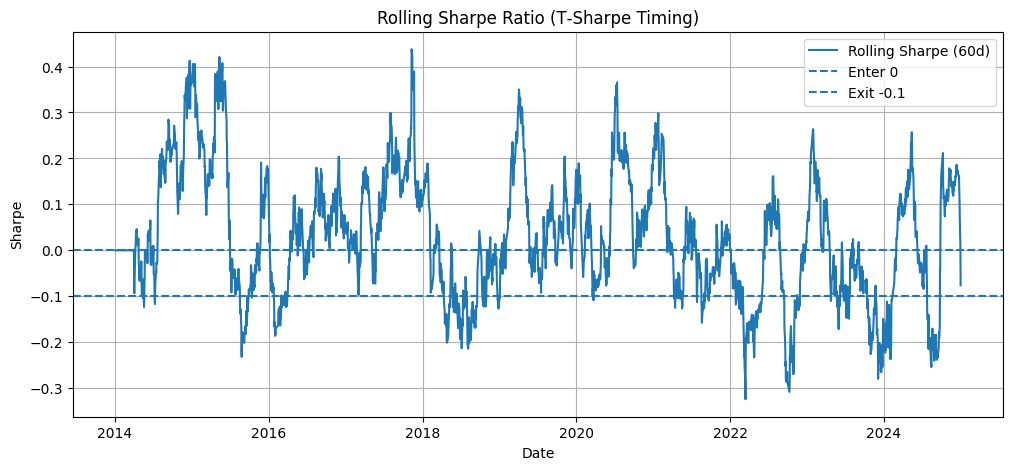

Rolling Sharpe Summary: {'mean': 0.030561818787862793, 'std': 0.1369301032915099, 'min': -0.32420270840801124, '25%': -0.06692336761666191, '50%': 0.016898671188674157, '75%': 0.12357897468866091, 'max': 0.43762096588844585}


In [88]:

def rolling_sharpe(ret: pd.Series, lookback=60):
    def _sh(x):
        x = np.asarray(x); sd = x.std(ddof=0)
        if sd == 0: return np.nan
        return x.mean()/sd
    return ret.rolling(lookback).apply(_sh, raw=True)

def tsharpe_signal(ret: pd.Series, lookback=60, enter=0.2, exit=-0.1, plot=True):
    rs = rolling_sharpe(ret, lookback).fillna(0.0)
    sig = pd.Series(0, index=rs.index, dtype=int); state = 0
    for dt, v in rs.items():
        if state==0 and v > enter: state = 1
        elif state==1 and v < exit: state = 0
        sig.loc[dt] = state

    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(rs.index, rs.values, label=f"Rolling Sharpe ({lookback}d)")
        plt.axhline(y=enter, linestyle="--", label=f"Enter {enter}")
        plt.axhline(y=exit, linestyle="--", label=f"Exit {exit}")
        plt.title("Rolling Sharpe Ratio (T‑Sharpe Timing)")
        plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.legend(); plt.grid(True); plt.show()

        summary = {"mean": float(rs.mean()), "std": float(rs.std()), "min": float(rs.min()),
                   "25%": float(rs.quantile(0.25)), "50%": float(rs.quantile(0.5)),
                   "75%": float(rs.quantile(0.75)), "max": float(rs.max())}
        print("Rolling Sharpe Summary:", summary)

    return sig, rs

tsh_sig_full, tsh_rs = tsharpe_signal(bm_daily_ret, TSHARPE_LOOKBACK, TSHARPE_ENTER, TSHARPE_EXIT, plot=True)
tsh_sig = tsh_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 10) Timing Combinations & Timing‑only Fees

In [89]:

# Gross returns with timing overlays
sel_rsrs_gross = sel_rets * rsrs_sig
sel_tsh_gross  = sel_rets * tsh_sig

combo_sig = ((rsrs_sig==1) | (tsh_sig==1)).astype(int)  # OR logic (change to & for AND)
sel_or_gross = sel_rets * combo_sig

# Timing‑only fees: charge costs when timing changes state (0↔1)
fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
rsrs_flip = rsrs_sig.diff().abs().fillna(0.0)
tsh_flip  = tsh_sig.diff().abs().fillna(0.0)
or_flip   = combo_sig.diff().abs().fillna(0.0)

sel_rsrs_net = sel_rsrs_gross - rsrs_flip * fee_per_flip
sel_tsh_net  = sel_tsh_gross  - tsh_flip  * fee_per_flip
sel_or_net   = sel_or_gross   - or_flip   * fee_per_flip


## 11) Partial Timing (Halve on Exit, Restore on Enter)

In [90]:

# Rule:
# - First enter (0→1): exposure = 100%
# - Exit (1→0): exposure *= 0.5
# - Re‑enter (0→1 again): exposure = 100%

exposure = 0.0; exposures, rets_partial = [], []
for dt, sig in combo_sig.items():
    if exposure == 0 and sig == 1:
        exposure = 1.0
    elif exposure > 0 and sig == 0:
        exposure = exposure * 0.7
    elif exposure < 1.0 and sig == 1:
        exposure = 1.0
    exposures.append(exposure)
    rets_partial.append(sel_rets.loc[dt] * exposure)

exposure_series = pd.Series(exposures, index=combo_sig.index, name="Exposure")
sel_with_partial_timing = pd.Series(rets_partial, index=combo_sig.index, name="PartialTiming")

# Timing‑only cost proportional to exposure change (Δexposure)
delta_exp = exposure_series.diff().abs().fillna(0.0)
sel_with_partial_timing_net = sel_with_partial_timing - delta_exp * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)


## 12) Plot Equity Curves (Gross & Net)

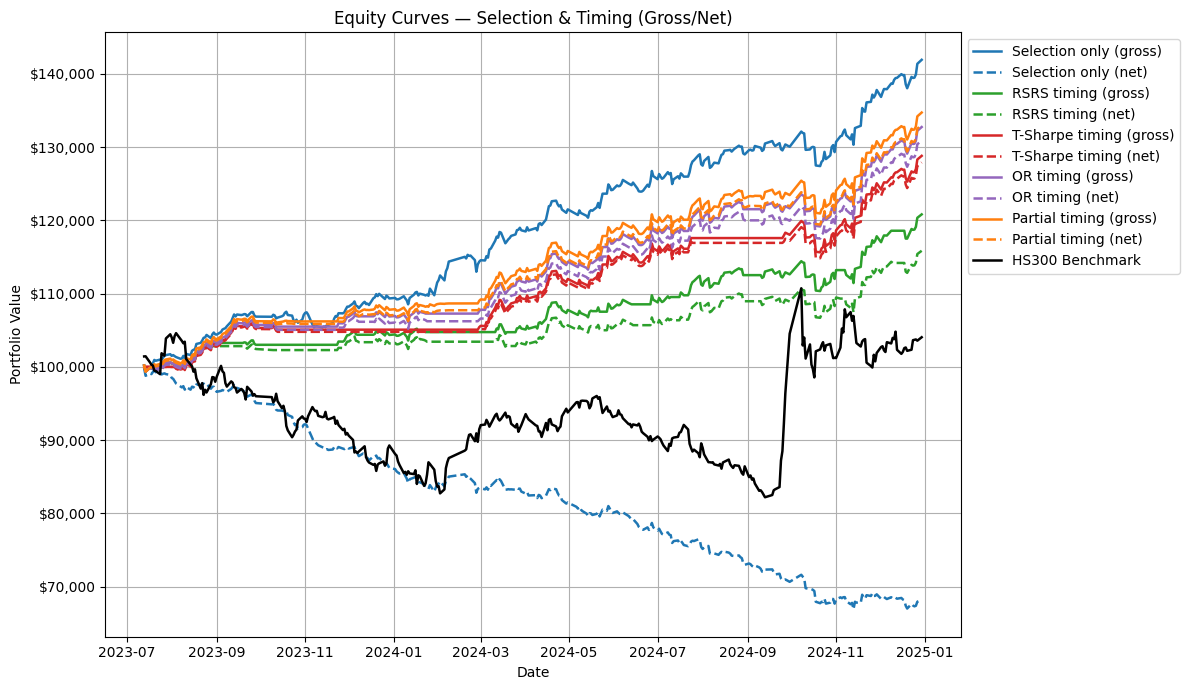

In [91]:

def plot_equity(series_dict, title="Equity Curves"):
    fig, ax = plt.subplots(figsize=(12,7))
    
    # Predefined colors by strategy group
    color_map = {
        "Selection": "tab:blue",
        "RSRS": "tab:green",
        "T-Sharpe": "tab:red",
        "OR": "tab:purple",
        "Partial": "tab:orange",
        "Benchmark": "black"
    }
    
    # Plot with style (gross=solid, net=dashed)
    for name, rets in series_dict.items():
        if rets is None or len(rets)==0: 
            continue
        eq = (1+rets).cumprod()*STARTING_CAPITAL
        
        # choose color by keyword
        c = None
        for key in color_map:
            if key in name:
                c = color_map[key]
                break
        if c is None:
            c = "gray"
        
        # solid line for gross, dashed for net
        style = "-" if "(gross)" in name else "--" if "(net)" in name else "-"
        
        ax.plot(eq.index, eq.values, label=name, color=c, linestyle=style, linewidth=1.8)
    
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value")
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f"${x:,.0f}"))
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # place legend outside plot
    ax.grid(True)
    plt.tight_layout()
    plt.show()

bm_aligned = bm_daily_ret.reindex(sel_rets.index).fillna(0.0)

plot_equity({
    "Selection only (gross)": selection_only_gross,
    "Selection only (net)": selection_only_net,
    "RSRS timing (gross)": sel_rsrs_gross,
    "RSRS timing (net)": sel_rsrs_net,
    "T-Sharpe timing (gross)": sel_tsh_gross,
    "T-Sharpe timing (net)": sel_tsh_net,
    "OR timing (gross)": sel_or_gross,
    "OR timing (net)": sel_or_net,
    "Partial timing (gross)": sel_with_partial_timing,
    "Partial timing (net)": sel_with_partial_timing_net,
    "HS300 Benchmark": bm_aligned
}, title="Equity Curves — Selection & Timing (Gross/Net)")



## 13) Performance Table

In [92]:

perf_df = pd.DataFrame({
    "selection_only_gross": selection_only_gross,
    "selection_only_net": selection_only_net,
    "rsrs_gross": sel_rsrs_gross,
    "rsrs_net": sel_rsrs_net,
    "tsharpe_gross": sel_tsh_gross,
    "tsharpe_net": sel_tsh_net,
    "or_gross": sel_or_gross,
    "or_net": sel_or_net,
    "partial_gross": sel_with_partial_timing,
    "partial_net": sel_with_partial_timing_net,
    "benchmark": bm_aligned
}).dropna(how="all")

if Strategy_performance is not None:
    Strategy_performance(perf_df, mark_benchmark="benchmark", periods="daily")
else:
    display(perf_df.tail())


In [93]:
def summarize_strategies(returns_dict, risk_free_rate=0.0, periods_per_year=252):
    """
    Summarize performance metrics for multiple return series.
    
    Parameters
    ----------
    returns_dict : dict of {name: pd.Series}
        Each value should be a daily return series.
    risk_free_rate : float
        Daily risk-free rate (default 0).
    periods_per_year : int
        Number of trading periods per year (default 252).
    
    Returns
    -------
    summary : pd.DataFrame
        Table with Annual Return, Volatility, Sharpe, Max Drawdown.
    """
    rows = []
    for name, rets in returns_dict.items():
        if rets is None or len(rets)==0:
            continue
        rets = rets.dropna()
        if len(rets)==0: continue
        
        # cumulative growth
        cum = (1+rets).cumprod()
        
        # metrics
        ann_ret = (cum.iloc[-1]**(periods_per_year/len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret - risk_free_rate) / vol if vol>0 else np.nan
        running_max = cum.cummax()
        dd = (cum/running_max - 1).min() *100
        
        rows.append({
            "Strategy": name,
            "Annual Return %": ann_ret,
            "Volatility %": vol,
            "Sharpe": sharpe,
            "Max Drawdown %": dd
        })
    
    return pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)

# ---- Call the function on all strategies ----
summary = summarize_strategies({
    "Selection Gross": selection_only_gross,
    "Selection Net": selection_only_net,
    "RSRS Gross": sel_rsrs_gross,
    "RSRS Net": sel_rsrs_net,
    "TSharpe Gross": sel_tsh_gross,
    "TSharpe Net": sel_tsh_net,
    "OR Gross": sel_or_gross,
    "OR Net": sel_or_net,
    "Partial Gross": sel_with_partial_timing,
    "Partial Net": sel_with_partial_timing_net,
    "Benchmark": bm_aligned
})

# Pretty print
pd.options.display.float_format = "{:.2%}".format
display(summary)


,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
Selection Gross,2804.41%,741.22%,378.35%,-357.05%
Partial Gross,2342.33%,671.76%,348.69%,-357.05%
Partial Net,2232.69%,672.33%,332.08%,-357.05%
OR Gross,2214.10%,670.47%,330.23%,-357.05%
TSharpe Gross,1957.34%,613.24%,319.18%,-357.05%
OR Net,2093.95%,672.03%,311.59%,-357.05%
TSharpe Net,1898.42%,613.56%,309.41%,-357.05%
RSRS Gross,1428.76%,621.89%,229.74%,-357.05%
RSRS Net,1094.96%,623.15%,175.71%,-357.05%


## 14) Macro-adjusted strategy

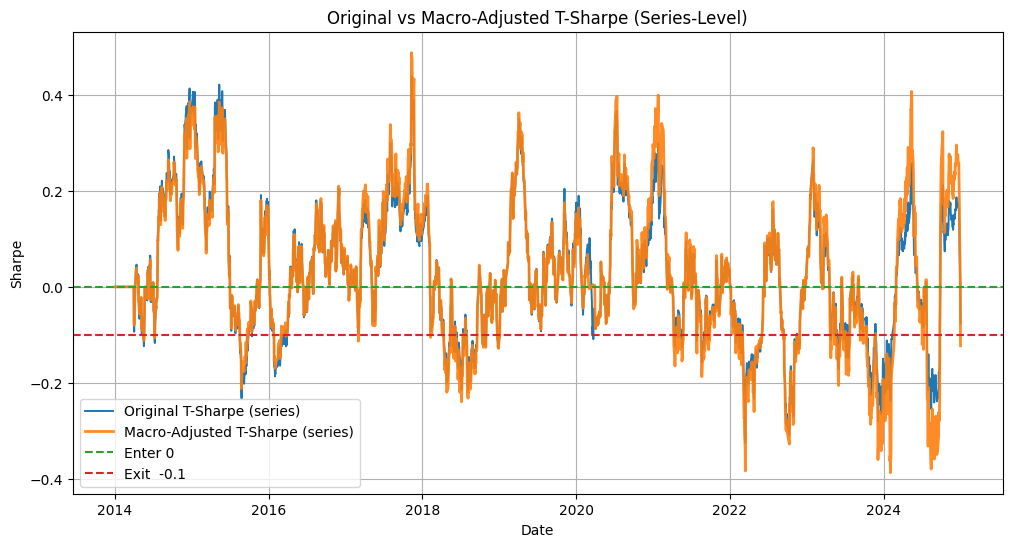

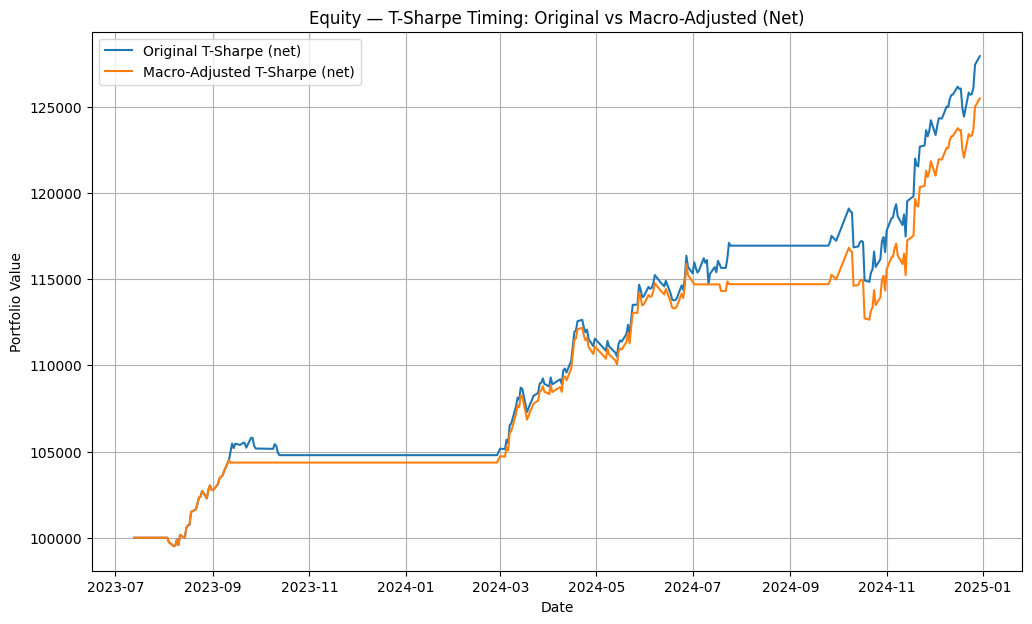

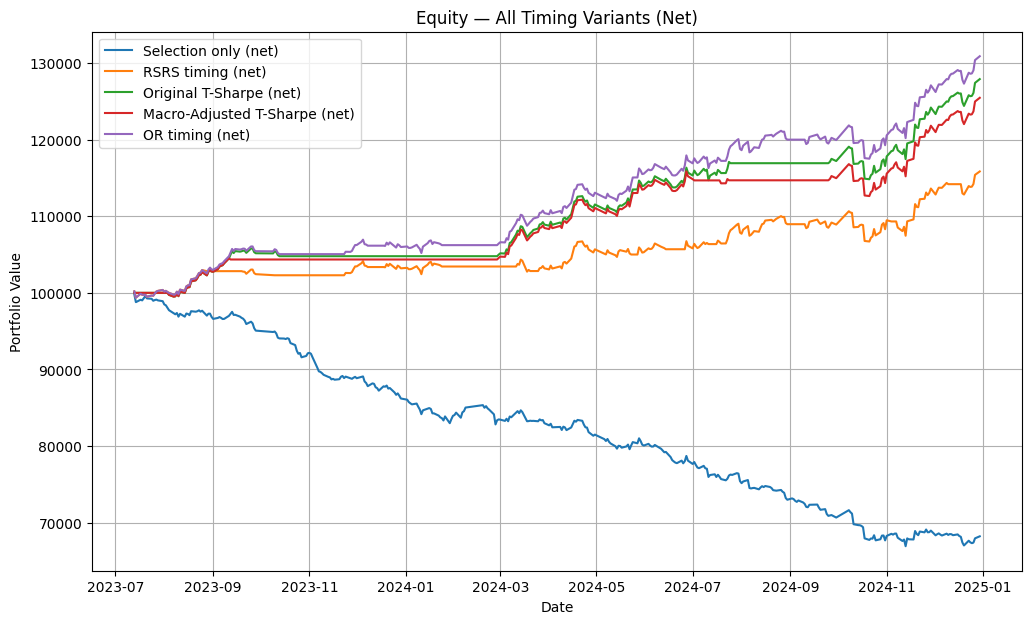

In [94]:
# === New Cell: Macro-Adjusted T-Sharpe using PMI, CPI, and M1 (no overwrite) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# 0) Robust path handling for your macro file
#    (tries your Windows paths first, then /mnt/data fallback)
# ------------------------------------------------------------
macro_candidates = [
    Path("F:/Code_Crunch/test/macroeconomics_CN.xlsx"),
]
macro_path = next((p for p in macro_candidates if p.exists()), None)
if macro_path is None:
    raise FileNotFoundError("Could not find 'macroeconomics_CN.xlsx' in any known location.")

# ------------------------------------------------------------
# 1) Load monthly macro data and coerce to numeric
# ------------------------------------------------------------
macro_m = pd.read_excel(macro_path, index_col=0)
macro_m.index = pd.to_datetime(macro_m.index, errors="coerce")
macro_m = macro_m[macro_m.index.notna()]

# Coerce all to numeric (handles %, commas)
for c in macro_m.columns:
    macro_m[c] = pd.to_numeric(
        macro_m[c].astype(str).str.replace("%","").str.replace(",",""),
        errors="coerce"
    )

# Keep only expected columns
expected_cols = ["PMI", "CPI", "M1"]
missing = [c for c in expected_cols if c not in macro_m.columns]
if missing:
    raise KeyError(f"Missing required macro columns in {macro_path.name}: {missing}. "
                   f"Found columns: {list(macro_m.columns)}")

macro_m = macro_m[expected_cols].copy()

# ------------------------------------------------------------
# 2) Z-score standardization (monthly)
# ------------------------------------------------------------
macro_std_m = (macro_m - macro_m.mean()) / macro_m.std()

# Composite macro score:
#   + M1 (liquidity)    -> boost exposure
#   + PMI (momentum)    -> boost exposure
#   - CPI (inflation)   -> reduce exposure
macro_std_m["macro_score"] = (
    0.4 * macro_std_m["M1"]
  - 0.3 * macro_std_m["CPI"]
  + 0.3 * macro_std_m["PMI"]
)

# ------------------------------------------------------------
# 3) Align monthly → daily → T-Sharpe index
#     Your notebook defines: tsh_rs (rolling Sharpe series)
# ------------------------------------------------------------
if 'tsh_rs' not in globals():
    raise RuntimeError("Expected 'tsh_rs' (rolling Sharpe series) not found. "
                       "Run the T-Sharpe cell first to create tsh_rs.")

# Resample monthly to daily by forward-fill, then align to tsh_rs index
macro_daily = macro_std_m.resample("D").ffill()
macro_on_tsh = macro_daily.reindex(tsh_rs.index).ffill()
macro_on_tsh["macro_score"] = macro_on_tsh["macro_score"].fillna(0.0)

# ------------------------------------------------------------
# 4) Build macro-adjusted T-Sharpe series and timing signal
#     Use your existing thresholds: TSHARPE_ENTER / TSHARPE_EXIT
# ------------------------------------------------------------
alpha = 0.5  # sensitivity factor; tune 0.3–0.8 if you like
tsh_rs_adj = tsh_rs * (1 + alpha * macro_on_tsh["macro_score"])

def tsharpe_signal_from_series(rs_series: pd.Series, enter: float, exit: float) -> pd.Series:
    """State machine on a precomputed Sharpe series to get a 0/1 timing signal."""
    sig = pd.Series(0, index=rs_series.index, dtype=int)
    state = 0
    for dt, v in rs_series.items():
        if state == 0 and v > enter:
            state = 1
        elif state == 1 and v < exit:
            state = 0
        sig.loc[dt] = state
    return sig

# Use your configured thresholds
tsh_sig_adj_full = tsharpe_signal_from_series(
    tsh_rs_adj, enter=TSHARPE_ENTER, exit=TSHARPE_EXIT
)

# Align adjusted timing to selection return index
tsh_sig_adj = tsh_sig_adj_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)

# ------------------------------------------------------------
# 5) Plots: original vs adjusted T-Sharpe series
# ------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(tsh_rs.index, tsh_rs.values,  label="Original T-Sharpe (series)", linewidth=1.4)
plt.plot(tsh_rs_adj.index, tsh_rs_adj.values, label="Macro-Adjusted T-Sharpe (series)", linewidth=2.0, alpha=0.9)
plt.axhline(TSHARPE_ENTER, linestyle="--", color="tab:green",  label=f"Enter {TSHARPE_ENTER}")
plt.axhline(TSHARPE_EXIT,  linestyle="--", color="tab:red",    label=f"Exit  {TSHARPE_EXIT}")
plt.title("Original vs Macro-Adjusted T-Sharpe (Series-Level)")
plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.grid(True); plt.legend()
plt.show()

# ------------------------------------------------------------
# 6) Strategy returns using adjusted timing (gross & net)
#     Mirrors your existing timing-cost model:
#       sel_tsh_gross  = sel_rets * tsh_sig
#       sel_tsh_net    = sel_tsh_gross - (flips * fee_per_flip)
# ------------------------------------------------------------
# Gross (adjusted)
sel_tsh_gross_adj = sel_rets * tsh_sig_adj

# Timing flip costs (use your existing fee model)
fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
tsh_flip_adj = tsh_sig_adj.diff().abs().fillna(0.0)

sel_tsh_net_adj = sel_tsh_gross_adj - tsh_flip_adj * fee_per_flip

# ------------------------------------------------------------
# 7) Equity curve comparison (original vs adjusted)
#     We DO NOT overwrite your existing variables (sel_tsh_gross, sel_tsh_net, etc.)
# ------------------------------------------------------------
def plot_equity_curves(series_dict, title):
    fig, ax = plt.subplots(figsize=(12,7))
    for name, rets in series_dict.items():
        if rets is None or len(rets) == 0:
            continue
        eq = (1 + rets).cumprod() * STARTING_CAPITAL
        ax.plot(eq.index, eq.values, label=name)
    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
    ax.legend(); ax.grid(True)
    plt.show()

plot_equity_curves({
    "Original T-Sharpe (net)": sel_tsh_net,
    "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
}, title="Equity — T-Sharpe Timing: Original vs Macro-Adjusted (Net)")

# (Optional) If you want to include selection-only and OR strategies for context:
plot_equity_curves({
    "Selection only (net)": selection_only_net,
    "RSRS timing (net)": sel_rsrs_net,
    "Original T-Sharpe (net)": sel_tsh_net,
    "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
    "OR timing (net)": sel_or_net,
}, title="Equity — All Timing Variants (Net)")


In [95]:
# ---- Call the function on all strategies ----
summary = summarize_strategies({
    "Selection Net": selection_only_net,
    "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
    "RSRS Net": sel_rsrs_net,
    "TSharpe Net": sel_tsh_net,
    "OR Net": sel_or_net,
    "Partial Net": sel_with_partial_timing_net,
    "Benchmark": bm_aligned
})

# Pretty print
pd.options.display.float_format = "{:.2%}".format
display(summary)

,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
Partial Net,2232.69%,672.33%,332.08%,-357.05%
OR Net,2093.95%,672.03%,311.59%,-357.05%
TSharpe Net,1898.42%,613.56%,309.41%,-357.05%
Macro-Adjusted T-Sharpe (net),1737.46%,585.81%,296.59%,-357.05%
RSRS Net,1094.96%,623.15%,175.71%,-357.05%
Benchmark,284.13%,1924.26%,14.77%,-2142.31%
Selection Net,-2367.49%,739.19%,-320.28%,-3297.37%


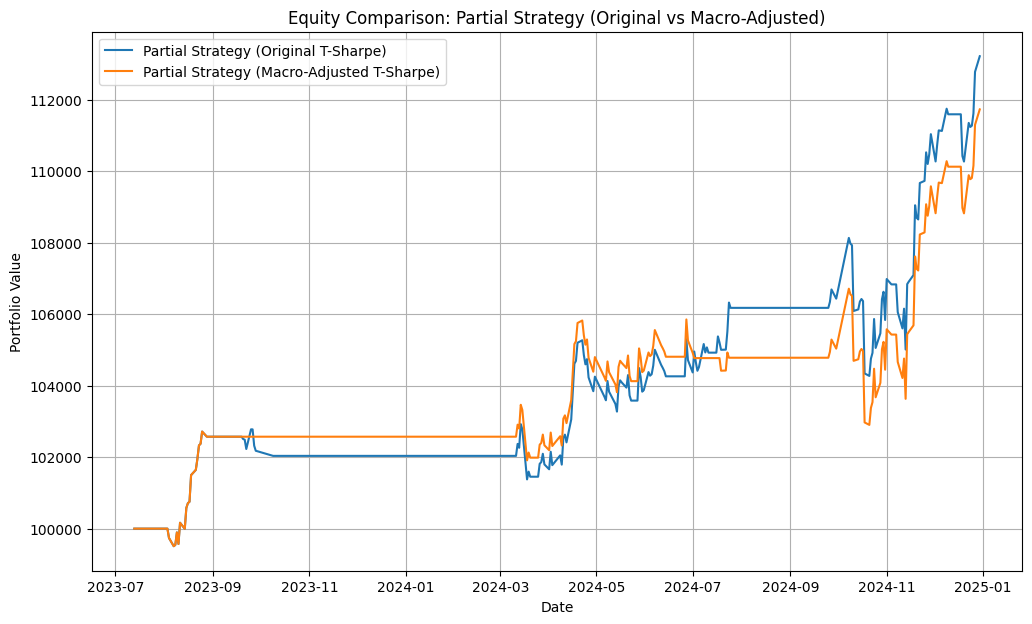

Performance summary (net returns):
Original Partial: {'Ann.Return': '9.16%', 'Volatility': '5.59%', 'Sharpe': '1.64'}
Macro-Adjusted Partial: {'Ann.Return': '8.14%', 'Volatility': '5.45%', 'Sharpe': '1.49'}


In [96]:
# === New Cell: Compare Original vs Macro-Adjusted T-Sharpe Partial Strategy ===
import matplotlib.pyplot as plt

# 1) Build partial strategies (combine selection + RSRS + T-Sharpe)
#    Your existing partial strategy likely multiplies all timing signals.
#    For safety we reconstruct both explicitly here.

# Original T-Sharpe partial (as in previous notebook logic)
partial_sig_orig = (tsh_sig & rsrs_sig).astype(int)  # logical AND of RSRS & T-Sharpe
partial_gross_orig = sel_rets * partial_sig_orig
partial_net_orig   = partial_gross_orig - partial_sig_orig.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# Macro-adjusted T-Sharpe partial strategy
partial_sig_adj = (tsh_sig_adj & rsrs_sig).astype(int)
partial_gross_adj = sel_rets * partial_sig_adj
partial_net_adj   = partial_gross_adj - partial_sig_adj.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# 2) Plot comparison of equity curves
def plot_equity(series_dict, title="Equity Comparison: Partial Strategy (Original vs Macro-Adjusted)"):
    fig, ax = plt.subplots(figsize=(12,7))
    for name, rets in series_dict.items():
        if rets is None or len(rets)==0: 
            continue
        eq = (1 + rets).cumprod() * STARTING_CAPITAL
        ax.plot(eq.index, eq.values, label=name)
    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
    ax.legend(); ax.grid(True)
    plt.show()

plot_equity({
    "Partial Strategy (Original T-Sharpe)": partial_net_orig,
    "Partial Strategy (Macro-Adjusted T-Sharpe)": partial_net_adj,
})

# 3) Optional: quick performance summary
def summary_stats(series):
    ann_return = (1 + series).prod() ** (252 / len(series)) - 1
    vol = series.std() * (252 ** 0.5)
    sharpe = ann_return / vol if vol != 0 else 0
    return {"Ann.Return": f"{ann_return:.2%}", "Volatility": f"{vol:.2%}", "Sharpe": f"{sharpe:.2f}"}

print("Performance summary (net returns):")
print("Original Partial:", summary_stats(partial_net_orig))
print("Macro-Adjusted Partial:", summary_stats(partial_net_adj))
